# <center> TP 4: Fisher Analysis <br>Linear Discriminant Analysis<br> <small>Réda DEHAK<br> 7 December 2018</small> </center>

The goal of this lab is :
    - Test the Fisher Analysis
    
We will use the [optdigits dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/) from UCI. This database is a small set of handwritten digits compared to the MNIST databases. A preprocessing program available by NIST was used to extract 64 features which represent the number of on pixel of nonoverlapping blocks of 4x4 extracted from normalized image. [See](optdigits.names.txt) for more details.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [76]:
dataTrain = pd.read_csv('optdigits.tra', header=None)
dataTest = pd.read_csv('optdigits.tes', header=None)

Xtrain = dataTrain.values[:,0:64]
ytrain = dataTrain.values[:,64]

Xtest = dataTest.values[:,0:64]
ytest = dataTest.values[:,64]

0- Examine dataset

In [77]:
print(set(ytrain))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


_Multiclass problem from the classical MNIST dataset_

In [78]:
print(Xtrain.shape)

(3823, 64)


$dim(x_i) = 64$

1- Try to use a Principal Component Analysis of the training data

In [79]:
from sklearn.decomposition import PCA

In [80]:
pca = PCA(n_components=20)
yhat_pca = pca.fit_transform(Xtrain)
print(yhat_pca.shape)

(3823, 20)


_The dimensionality is reduced to 3._

2- Plot each example of the training data in the first two factorial axis of PCA(2D space), use different color foreach classe? what did you conclude?

/home/nicolas/.anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


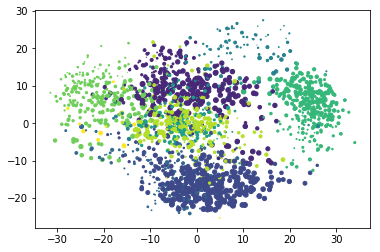

In [81]:
plt.scatter(yhat_pca[:, 0], yhat_pca[:, 1], yhat_pca[:, 2], c=ytrain)
plt.show()

3- Train a logistic regression on the projected data into the $d$ first factorial axis of PCA, and test the results on the testing data? try different values of $d$?    

In [82]:
from sklearn.linear_model import LogisticRegression

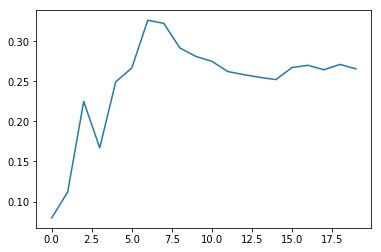

In [83]:
logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
yhat_pca_test = pca.fit_transform(Xtest)
scores = []
for d in range(1, yhat_pca.shape[1] + 1):
    yhat_class = logreg.fit(yhat_pca[:, :d], ytrain)
    scores.append(logreg.score(yhat_pca_test[:, :d], ytest))
    
plt.plot(scores)

_As we can see, the results are disapointing with the PCA dimension reduction. Our maximum accuracy is around 0.30, which is not good at all for this quite simple problem._

4- We will try a Linear Discriminant Analysis method to separate the 10 classes. Train a Linear Discriminant Analysis on the training data and plot each example in the 2d plan corresponding to the two axis with largest eigen values? what did you conclude?   

_1) Compute the class means $\mu_k$_

In [174]:
K = len(set(ytrain))
D = Xtrain.shape[1]
Mu = np.zeros((K, D))

for k in range(K):
    C = [x for x, y in zip(Xtrain, ytrain) if y == k]
    Mu[k] = np.mean(C, axis=0)

print(Mu.shape)

(10, 64)


2) _Compute the within-class scatter matrix $S_W$:_

$$S_W = \sum_{i=0}^n(x_i - \mu_{y_i})(x_i - \mu_{y_i})^T$$

In [176]:
#S_W = np.zeros((D, D))

#for k in range(K):
#    selected = Xtrain[ytrain == k].astype(np.float32)
#    selected -= Mu[k]
#    S_W += selected.T @ selected

X_k_centered = Xtrain - (Mu.T @ to_categorical(ytrain).T).T
S_W = X_k_centered.T @ X_k_centered
print(np.max(S_W - test), np.min(S_W -test))
print(np.linalg.norm(S_W - test))

0.0 0.0
0.0


_3) Compute the between-class scatter matrix $S_B$:_

In [177]:
m = np.mean(Mu, axis=0)
S_B = np.zeros((D, D))
Mu_c = Mu - m

for k in range(K):
    N = Xtrain[ytrain == k].shape[0]
    mk = Mu_c[k].reshape(-1, 1)
    S_B += N * (mk @ mk.T)

_4) Sorting the eigenvalues_

In [178]:
lam, V = np.linalg.eigh(np.linalg.pinv(S_W).dot(S_B))
lam, V = zip(*sorted(zip(np.abs(lam), V.T), key=lambda p: -p[0]))
lam, V = np.array(lam), np.array(V).T

s = np.sum(lam)
for i, val in enumerate(lam[:min(15, len(lam))]):
    print('eigenvalue {0:}: {1:.2%}'.format(i + 1, (val / s)))

eigenvalue 1: 21.50%
eigenvalue 2: 20.37%
eigenvalue 3: 10.50%
eigenvalue 4: 9.61%
eigenvalue 5: 6.30%
eigenvalue 6: 5.96%
eigenvalue 7: 3.34%
eigenvalue 8: 2.92%
eigenvalue 9: 2.40%
eigenvalue 10: 1.74%
eigenvalue 11: 1.70%
eigenvalue 12: 1.22%
eigenvalue 13: 1.14%
eigenvalue 14: 1.09%
eigenvalue 15: 0.82%


5- Train a logistic regression on the projected data into the $d$ first axis of LDA? what did you remark and how to solve this problem?

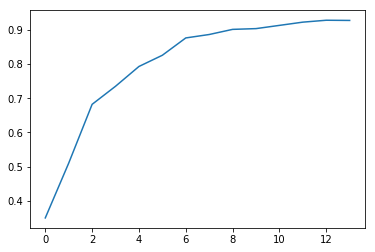

In [179]:
logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')

scores = []
for d in range(1, min(15, len(lam))):
    proj_mat = V[:, :d]
    lda_reduced = Xtrain @ proj_mat
    logreg.fit(lda_reduced, ytrain)
    lda_reduced_test = Xtest @ proj_mat
    scores.append(logreg.score(lda_reduced_test, ytest))

plt.plot(scores)
plt.show()

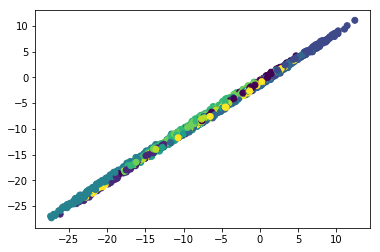

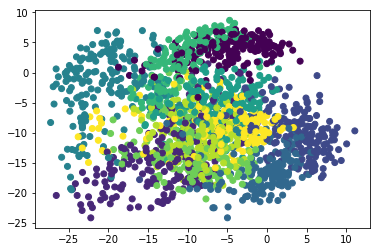

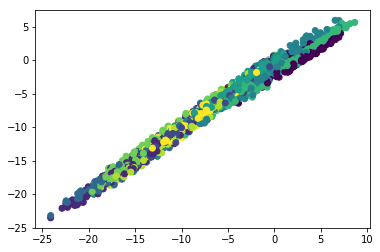

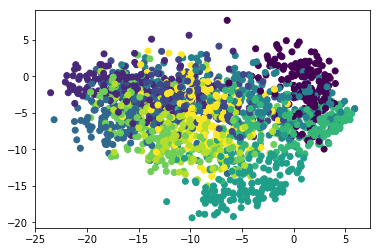

In [191]:
yhat = Xtest @ V[:, :12]
plt.scatter(yhat[:, 0], yhat[:, 1], c=ytest)
plt.show()
plt.scatter(yhat[:, 1], yhat[:, 2], c=ytest)
plt.show()
plt.scatter(yhat[:, 2], yhat[:, 3], c=ytest)
plt.show()
plt.scatter(yhat[:, 3], yhat[:, 4], c=ytest)
plt.show()

_The comparison with the PCA reduced data is neat. LDA obviously gives a better dimensionality reduction for linear multiclass separation_

6- Do the same task with the MNIST dataset?

_Maybe another day :)_